In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import optim
import syndata
from syndata import grid_pop
import align
import mgplvm
from mgplvm import kernels, rdist
from mgplvm.manifolds import Torus, Euclid
from mgplvm.models import Core
from mgplvm.training import train
plt.rcParams.update({'font.size': 22})

np.random.seed(19432310)

In [2]:
#%% generate synthetic grid cell data

cells = grid_pop(n_modules = 1, n_c = 10, lambda0 = 3.5)
X = cells.gen_trajec_GP(tmax = 100, T = 700, l = 1, sig = 10)
Y = cells.calc_G(X = None)
Y = Y+np.random.normal(0, 1, size = Y.shape)*np.amax(Y)/5 #add some noise

n, m = Y.shape
Y = np.expand_dims(Y, 2)

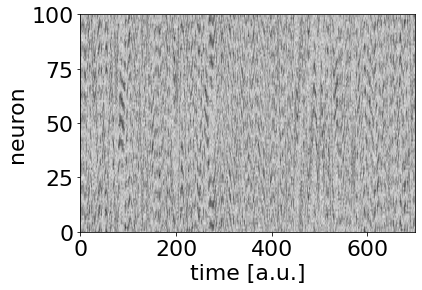

<ipython-input-3-5680fdf76641>:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks([-0.5, nx-0.5], [xmin, xmax])
<ipython-input-3-5680fdf76641>:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_yticks([-0.5, nx-0.5], [xmin, xmax])


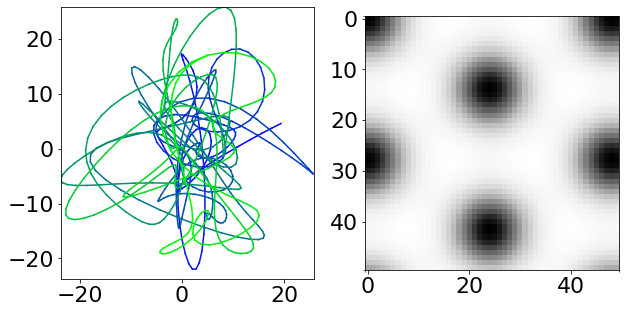

In [3]:
#%% plot synthetic data

plt.figure()
Yplot = Y[:, :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,m)
plt.ylim(0,n)
plt.show()
plt.close()

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

cols = [[0, i/m, 1-i/m] for i in range(m)]
for i in range(1, m):
    xs, ys = [[X[i-1,j], X[i, j]] for j in range(2)]
    axs[0].plot(xs, ys, '-', c = cols[i])
axs[0].set_xlim(np.amin(X), np.amax(X))
axs[0].set_ylim(np.amin(X), np.amax(X))

xmin, xmax, nx = 0, 10, 50
example_tuning = cells.modules[0].cells[0].comp_tuning(xmin, xmax, nx)
axs[1].imshow(example_tuning, cmap = 'Greys')
axs[1].set_xticks([-0.5, nx-0.5], [xmin, xmax])
axs[1].set_yticks([-0.5, nx-0.5], [xmin, xmax])

plt.show()
    

In [4]:
#%% initialize model

torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")



d = 2  # dims of latent space
n_z = 15  # number of inducing points


# specify manifold, kernel and rdist
manif = Torus(m, d)
sig0 = 1.5
ref_dist = mgplvm.rdist.MVN(m, d, sigma=sig0)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.QuadExp(n, manif.distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
mod = Core(manif, n, m, n_z, kernel, ref_dist, sigma=sigma).to(device)

In [5]:
# train model
trained_mod = train(Y,
                    mod,
                    device,
                    optimizer=optim.Adam,
                    outdir='none',
                    max_steps=600,
                    burnin=200,
                    n_b=64,
                    lrate=5E-2,
                    print_every=50)

data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
mod = mod.to(device)
mulearn = mod.manif.prms.data.cpu().numpy()

(699, 2)


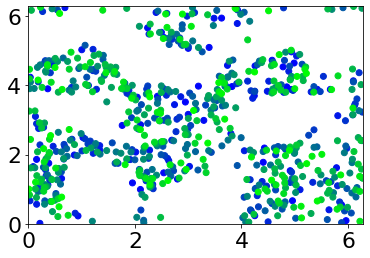

In [8]:
#%% plot latent state over time
mulearn = mod.manif.prms.data.cpu().numpy()[:-1, :]
if 'Torus' in manif.name:
    mulearn = (mulearn+20*np.pi ) %(2*np.pi)
m = mulearn.shape[0]
cols = [[0, i/m, 1-i/m] for i in range(m)]
print(mulearn.shape)
plt.figure()
plt.scatter(mulearn[:,0], mulearn[:,1], c = cols)
if 'Torus' in manif.name:
    plt.xlim(0, 2*np.pi)
    plt.ylim(0, 2*np.pi)
plt.show()


In [9]:
#%% consider 'tuning curves'

nx = 20
if 'Torus' in manif.name:
    q = np.linspace(0, 2*np.pi, nx)
else:
    q = np.linspace(np.amin(mulearn), np.amax(mulearn), nx)
q1, q2 = np.meshgrid(*[q, q])
query = np.array([q1.flatten(), q2.flatten()]).T

query = torch.tensor(query,
                     dtype=torch.get_default_dtype(),
                     device=device)

fmean, fstd = mod.predict(data, query, niter=100)
mean = fmean.cpu().numpy()

true_tunings = cells.comp_tuning(0, 3, nx)


100


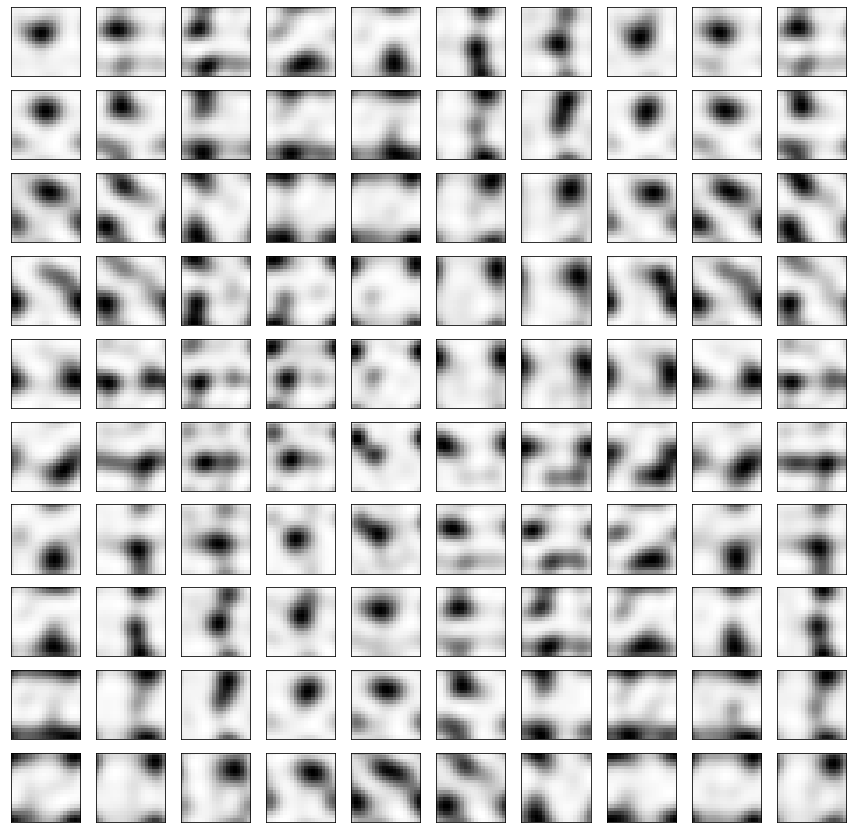

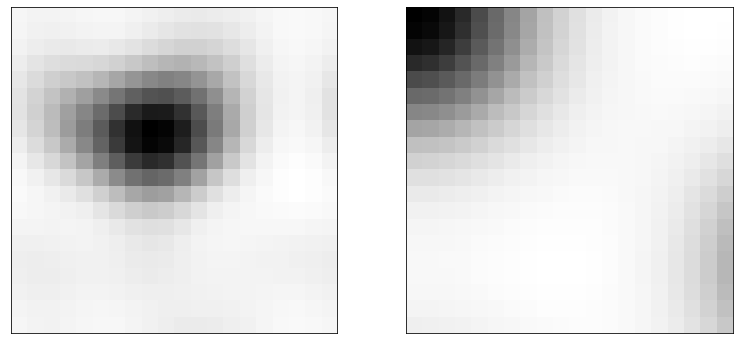

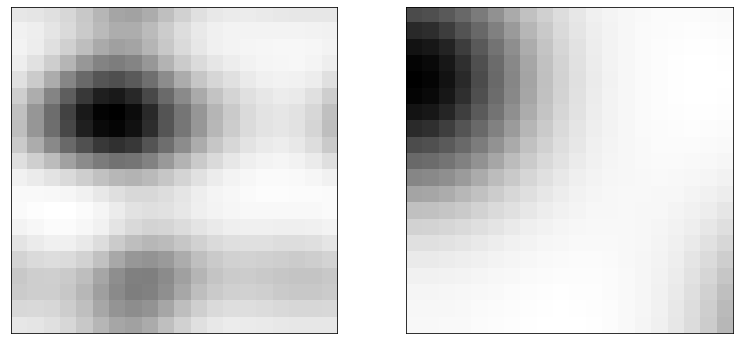

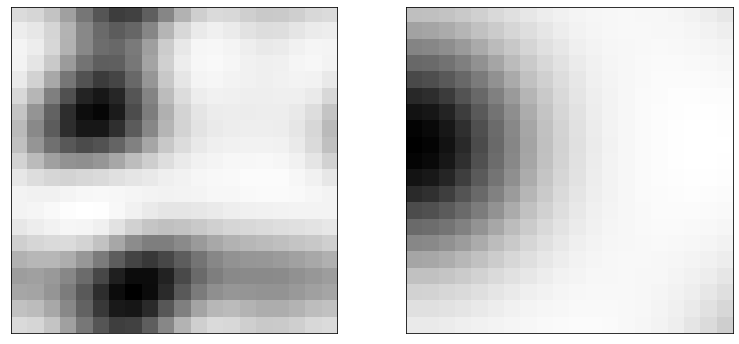

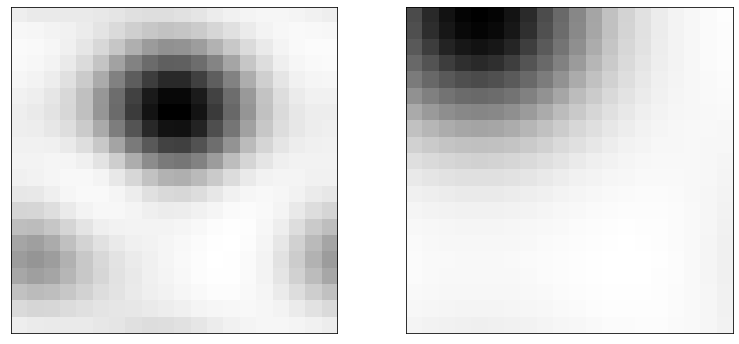

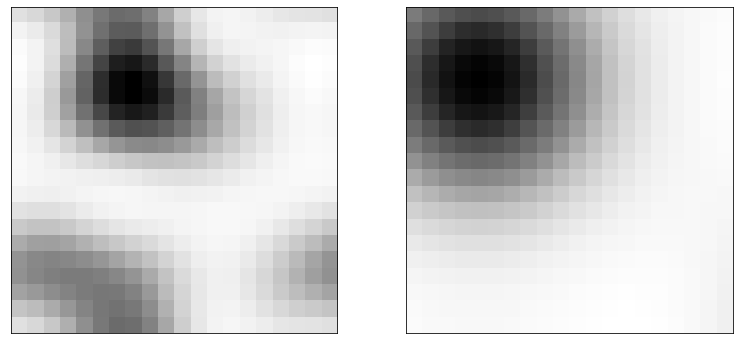

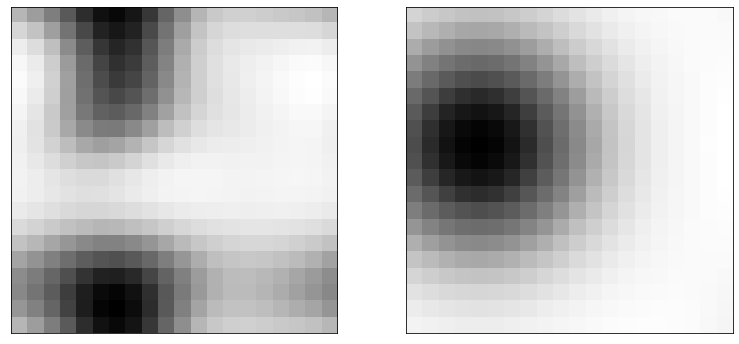

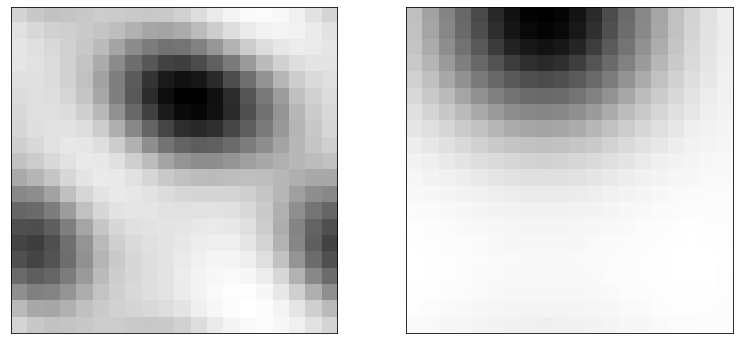

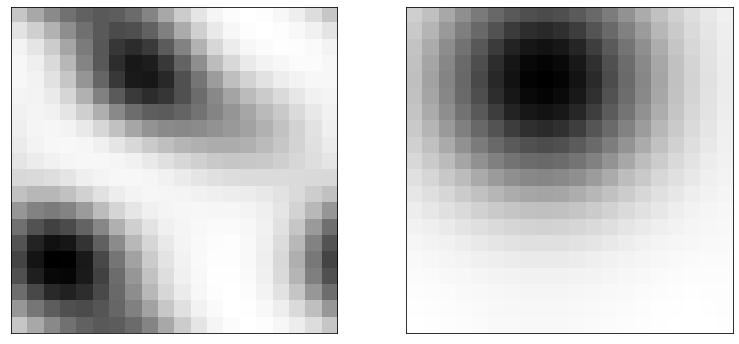

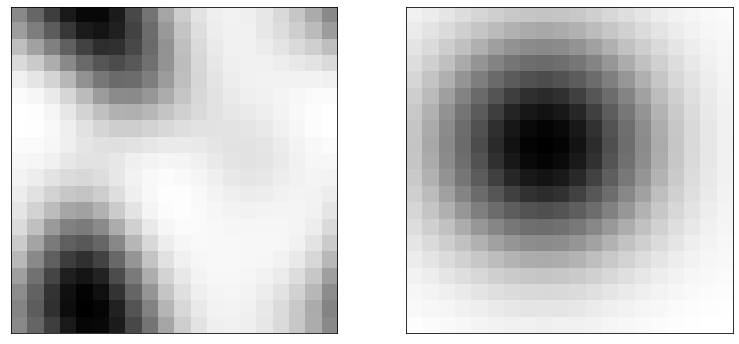

In [10]:
#%% plot tuning curves
print(n)
n_c = cells.n_c

#%%plot all tunings
fig, axs = plt.subplots(n_c, n_c, figsize = (15, 15))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(mean[i, :, 0].reshape(nx, nx), cmap = 'Greys')
    [f([]) for f in [ax.set_xticks, ax.set_yticks]]
plt.show()
plt.close()
    

#%%copmare to ground truth
inds = np.concatenate([[i*n_c+j for j in range(3)] for i in range(3)])
for i in inds:
    fig, axs = plt.subplots(1,2, figsize=(13, 6))
    axs[0].imshow(mean[i, :, 0].reshape(nx, nx), cmap = 'Greys')
    axs[1].imshow(true_tunings[i], cmap = 'Greys')
    for j in range(2):
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.show()
    plt.close()


